In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/ml-project-2-roadmen-bruv/

/content/drive/MyDrive/ml-project-2-roadmen-bruv


In [ ]:
if True:
  %cd /content/drive/MyDrive/ml-project-2-roadmen-bruv/
if False:
  %cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
if False:
  %cd "/content/drive/MyDrive/EPFL/MachineLearningMA3/Project 2/ml-project-2-roadmen-bruv"

## Git

In [ ]:
!git status

Refresh index: 100% (12/12), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   runEd.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git pull

Already up to date.


In [ ]:
!git add .

In [ ]:
!git config --global user.email "edwin.bertschy@epfl.ch"
!git config --global user.email "ebertschy"

In [ ]:
!git commit -m "add folder pred_Unet and tests"

[main a1b124b] add folder pred_Unet and tests
 2 files changed, 627 insertions(+), 97 deletions(-)
 create mode 100644 pred_Unet/Unet_submission.csv
 rewrite runEd.ipynb (85%)


In [ ]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 1.27 MiB | 3.31 MiB/s, done.
Total 5 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/CS-433/ml-project-2-roadmen-bruv
   e981c1d..a1b124b  main -> main


## Installation

In [ ]:
!pip install -U segmentation-models-pytorch==0.3.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.6 MB/s eta 0:00:00


In [ ]:
#!pip install albumentations==1.3.1

In [ ]:
# !pip install pytorch-lightning==2.1.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 64.9 MB/s eta 0:00:00


In [ ]:
# !pip install torchsummary --quiet

## U-net

In [ ]:
#imports
%load_ext autoreload
%autoreload 2
import segmentation_models_pytorch as smp
# import segmentation_models_pytorch.utils.metrics as smpbis
import albumentations as albu
import os
from os import listdir
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
# import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader,  random_split
from sklearn.metrics import f1_score
import random
# import torchsummary

In [ ]:
%ls

best_model.pth  helpers/     lightning_logs/  README.md  runEd.ipynb  runTomas.ipynb  submissions/
data/           __init__.py  pred_Unet/       results/   run.ipynb    runVic.ipynb    utils/


In [ ]:
import sys
sys.path.append('./helpers/')
from mask_to_submission import masks_to_submission
import sys
sys.path.append('./utils/')
from data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset

In [ ]:
%reload_ext autoreload

In [ ]:
print(f"smp: {smp.__version__}, albu: {albu.__version__}, cv2: {cv2.__version__}, pl: {pl.__version__}")
# smp: 0.3.3, albu: 1.3.1, cv2: 4.8.0, pl: 2.1.1

smp: 0.3.3, albu: 1.3.1, cv2: 4.8.0, pl: 2.1.1


In [ ]:
# print(dir(torchsummary))

['__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'summary', 'torchsummary']


In [ ]:
# print(torchsummary.__spec__)

ModuleSpec(name='torchsummary', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7db1a22fb040>, origin='/usr/local/lib/python3.10/dist-packages/torchsummary/__init__.py', submodule_search_locations=['/usr/local/lib/python3.10/dist-packages/torchsummary'])


## subparts images

In [ ]:
def extract_subparts(arr, height, width):
    if height > len(arr) or width > len(arr[0]):
        raise ValueError("Height or width is larger than the input array dimensions")

    upper_left = arr[:height, :width]
    upper_right = arr[:height, -width:]
    lower_left = arr[-height:, :width]
    lower_right = arr[-height:, -width:]

    return upper_left, upper_right, lower_left, lower_right

In [ ]:
def concatenate_subparts(upper_left, upper_right, lower_left, lower_right, width=608, height=608, w_contrib=304, h_contrib=304):
    upper_left = upper_left[:h_contrib, :w_contrib]
    upper_right = upper_right[:h_contrib, -w_contrib:]
    lower_left = lower_left[-h_contrib:, :w_contrib]
    lower_right = lower_right[-h_contrib:, -w_contrib:]

    upper_half = np.hstack((upper_left, upper_right))
    lower_half = np.hstack((lower_left, lower_right))

    return np.vstack((upper_half, lower_half))

In [ ]:
import numpy as np

def concatenate_subparts(upper_left, upper_right, lower_left, lower_right, width=608, height=608, w_contrib=304, h_contrib=304):
    upper_left = upper_left[:h_contrib, :w_contrib]
    upper_right = upper_right[:h_contrib, -w_contrib:]
    lower_left = lower_left[-h_contrib:, :w_contrib]
    lower_right = lower_right[-h_contrib:, -w_contrib:]

    upper_half = np.hstack((upper_left, upper_right))
    lower_half = np.hstack((lower_left, lower_right))

    return np.vstack((upper_half, lower_half))

# Example usage:
array_2d = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
height = 2
width = 2

upper_left, upper_right, lower_left, lower_right = extract_subparts(array_2d, height, width)

concatenated_array = concatenate_subparts(upper_left, upper_right, lower_left, lower_right, width=4, height=4,  w_contrib=2, h_contrib=2)

print("Original Array:\n", array_2d)
print("\nConcatenated Array:\n", concatenated_array)

Original Array:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

Concatenated Array:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]


In [ ]:
import numpy as np

def extract_subparts(arr, height, width):
    if height > len(arr) or width > len(arr[0]):
        raise ValueError("Height or width is larger than the input array dimensions")

    upper_left = arr[:height, :width]
    upper_right = arr[:height, -width:]
    lower_left = arr[-height:, :width]
    lower_right = arr[-height:, -width:]

    return upper_left, upper_right, lower_left, lower_right

# Example usage:
array_2d = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
height = 2
width = 2

upper_left, upper_right, lower_left, lower_right = extract_subparts(array_2d, height, width)

print("Upper Left:\n", upper_left)
print("\nUpper Right:\n", upper_right)
print("\nLower Left:\n", lower_left)
print("\nLower Right:\n", lower_right)

Upper Left:
 [[1 2]
 [4 5]]

Upper Right:
 [[2 3]
 [5 6]]

Lower Left:
 [[4 5]
 [7 8]]

Lower Right:
 [[5 6]
 [8 9]]


## Cascade model

In [ ]:
# Global parameters

# Model architecture #
arch = 'Unet'
encoder_name = 'resnet34' # resnet18 instead of resnet34 (by default)?
in_channels = 3 # 1 instead of 3 for RGB satellite images
classes = 1
activation = 'sigmoid'
encoder_weights = 'imagenet' #by default

# Loss #
# Diceloss
# Args:
#             mode: Loss mode 'binary', 'multiclass' or 'multilabel'
#             classes:  List of classes that contribute in loss computation. By default, all channels are included.
#             log_loss: If True, loss computed as `- log(dice_coeff)`, otherwise `1 - dice_coeff`
#             from_logits: If True, assumes input is raw logits
#             smooth: Smoothness constant for dice coefficient (a)
#             ignore_index: Label that indicates ignored pixels (does not contribute to loss)
#             eps: A small epsilon for numerical stability to avoid zero division error
#                 (denominator will be always greater or equal to eps)

# Optimisation #
# Adam
# betas=(0.9, 0.999)
learning_rate = 1e-4
# decreasing learning rate
# max_epochs
DEVICE = 'cuda'

# Image #
MASK_THRESHOLD = 120
SIZE_X = 416 #divisible by 32
SIZE_Y = 416 #divisible by 32
# preprocessing (normalisation)

# Training and validation #
# split_ratio
# augmentation

# Metrics #
# f1_score pixel wise
# f1_score patch wise

# paths
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
# PATH_IMG_TRAIN = "./data/training/images/"
# PATH_MASK_TRAIN = "./data/training/groundtruth/"
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_TEST_IMG = "./data/test_set_images/"

In [ ]:
# create model
model = smp.create_model(arch=arch, encoder_name=encoder_name, in_channels=in_channels, classes=classes, activation=activation, encoder_weights=encoder_weights)

In [ ]:
def load_resize_image_preprocessing_optional(path_img=None, path_mask=None, size_y=416, size_x=416, mask_thr=120, preprocessing_fn=None):
    if path_img is None and path_mask is None:
        print('No path given')
        return

    if path_img is not None:
        images = listdir(path_img)
        images = [img for img in images if img.endswith(".png")]
    else:
        images = listdir(path_mask)
        images = [img for img in images if img.endswith(".png")]

    images.sort()
    img_list = []
    mask_list = []

    for image in images:
        # satellite image
        if path_img is not None:
            img = cv2.imread(path_img + image, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (size_y, size_x))
            # img = img.transpose((2, 0, 1))
            img_list.append(img)
        # mask
        if path_mask is not None:
            mask = cv2.imread(path_mask + image, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (size_y, size_x))
            mask[mask<mask_thr] = 0 #pixel value {0, 255}
            mask[mask>mask_thr] = 255
            # mask = mask[np.newaxis, ...]
            # mask = mask.transpose(((2, 0, 1)))
            mask_list.append(mask)
        break ###

    if preprocessing_fn is not None:
        if path_img is not None:
            if path_mask is not None:
                preprocessed = albu.Lambda(image=preprocessing_fn)(image=np.array(img_list), mask=np.array(mask_list))
                return np.array(preprocessed['image']), np.array(preprocessed['mask'])
            else:
                preprocessed = albu.Lambda(image=preprocessing_fn)(image=np.array(img_list))
                return np.array(preprocessed['image'])
        else:
            print('Cannot preprocess only masks.')
            return np.array(mask_list)

    else:
        if path_img is not None:
            if path_mask is not None:
                return np.array(img_list), np.array(mask_list)
            else:
                return np.array(img_list)
        else:
            return np.array(mask_list)
# torch.FloatTensor(np.array(test_img).transpose((0, 3, 1, 2)))

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, encoder_weights)
img_tr, mask_tr = load_resize_image_preprocessing_optional(path_img=PATH_TR_IMG_AUG_RAW,path_mask=PATH_TR_MASK_AUG_RAW, size_y=SIZE_Y, size_x=SIZE_X, mask_thr=MASK_THRESHOLD, preprocessing_fn=preprocessing_fn)

In [ ]:
print(img_tr.shape, mask_tr.shape)

(1, 416, 416, 3) (1, 416, 416)


In [ ]:
img_tr = img_tr.transpose((0, 3, 1, 2))
mask_tr = mask_tr[..., np.newaxis].transpose((0, 3, 1, 2))

In [ ]:
print(img_tr.shape, mask_tr.shape)

(1, 3, 416, 416) (1, 1, 416, 416)


In [ ]:
tr = TensorDataset(torch.FloatTensor(img_tr), torch.FloatTensor(mask_tr))

In [ ]:
img_val, mask_val = load_resize_image_preprocessing_optional(path_img=PATH_VAL_IMG_RAW,path_mask=PATH_VAL_MASK_RAW, size_y=SIZE_Y, size_x=SIZE_X, mask_thr=MASK_THRESHOLD, preprocessing_fn=preprocessing_fn)

In [ ]:
img_val = img_val.transpose((0, 3, 1, 2))
mask_val = mask_val[..., np.newaxis].transpose((0, 3, 1, 2))

In [ ]:
val = TensorDataset(torch.FloatTensor(img_val), torch.FloatTensor(mask_val))

In [ ]:
tr_dataloader = DataLoader(tr, batch_size=32, shuffle=True) # create a dataloader => not really useful ?
val_dataloader = DataLoader(val, batch_size=1, shuffle=False)

## test load_resize_...

In [ ]:
img_test = load_resize_image_preprocessing_optional(path_img=PATH_TEST_IMG+'test_1/', size_y=608, size_x=608)

In [ ]:
mask_only = load_resize_image_preprocessing_optional(path_mask=PATH_TR_MASK_AUG_RAW, size_y=SIZE_Y, size_x=SIZE_X, mask_thr=MASK_THRESHOLD, preprocessing_fn=preprocessing_fn)

Cannot preprocess only masks.


In [ ]:
print(mask_only.shape)

(80, 416, 416)


In [ ]:
print(img_tr.shape, mask_tr.shape)
# plt.imshow(img_tr[0])
# plt.hist(mask_tr[0].ravel(), density=True, color='red')

(1, 416, 416, 3) (1, 416, 416)


In [ ]:
print(img_test.shape)

(1, 608, 608, 3)


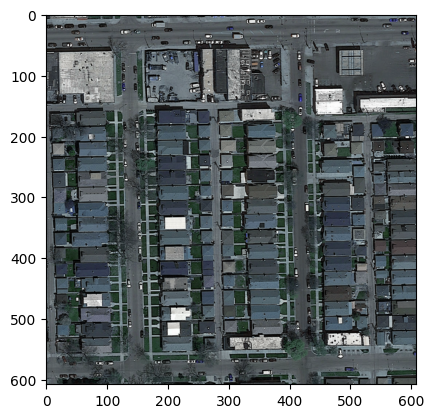

In [ ]:
plt.imshow(img_test[0])

## fin test load_resize_...

In [ ]:
# load images
_ , train_mask = load_img_training(PATH_TR_IMG_AUG, PATH_TR_MASK_AUG) #définir une autre fonction pour load et preprocess

In [3]:
height, width = (32,32)
patch_size = 16
for y in range(0, height, patch_size):
    for x in range(0, width, patch_size):
        print(y//16, x//16)

0 0
0 1
1 0
1 1


In [ ]:
class F1score(smp.utils.base.Metric): # edit for patch
  def __init__(self, threshold=0.5, activation=None, **kwargs):
      super().__init__(**kwargs)
      self.threshold = threshold
      self.activation = smp.base.modules.Activation(activation)
  # def forward(self, batch):
  def forward(self, y_pr, y_gt) #pr = predicted, gt = groundtruth
      # x, y_true = batch
      # mask_logits = self.forward(x)  #forward method returns predictions
      y_pr = self.activation(y_pr)
      # mask_probs = mask_logits.sigmoid()
      y_pr = (y_pr > 0.5).float() #=> value 0.0 or 1.0
      tp, fp, fn, tn = smp.metrics.get_stats(y_pr, y_gt, mode='binary', threshold=self.threshold)
      return smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

In [ ]:
from sklearn.metrics import f1_score
class F1score_patch(smp.utils.base.Metric):
  def __init__(self, threshold=0.5, activation=None, patch_thr=0.25, patch_size=16, **kwargs):
      super().__init__(**kwargs)
      self.threshold = threshold
      self.activation = smp.base.modules.Activation(activation)
      self.patch_thr = patch_thr
      self.patch_size = patch_size
  def forward(self, y_pr, y_gt) #pr => predicted, gt => groundtruth
      y_pr = self.activation(y_pr)
      y_pr = (y_pr > self.threshold).float() #=> value 0.0 or 1.0

      # Detach from gpu
      y_pr = y_pr.detach().cpu().numpy()
      y_gt = y_gt.detach().cpu().numpy()
      # Initialize list for patches
      y_pr_patch = []
      y_gt_patch = []

      height, width = y_pr.shape
      for y in range(0, height, patch_size):
          for x in range(0, width, patch_size):
              # Extract the patch
              patch_pr = y_pr[y:y + patch_size, x:x + patch_size]
              patch_gt = y_gt[y:y + patch_size, x:x + patch_size]
              # Calculate the average of the patch
              patch_avg_pr = np.mean(patch_pr)
              patch_avg_gt = np.mean(patch_gt)
              if (patch_avg_pr > self.patch_thr):
                  y_pr_patch.append(1)
              else:
                  y_pr_patch.append(0)
              if (patch_avg_gt > self.patch_thr):
                  y_gt_patch.append(1)
              else:
                  y_gt_patch.append(0)

      f1_score_patch = f1_score(y_gt_patch, y_pr_patch) #from sklearn.metrics import f1_score
      return f1_score_patch

#prediction[..., 0] # is equivalent to prediction[:,:,:,:,0] for torch arrays
F1score(activation='sigmoid') # add to the metrics

In [ ]:
patch_size_big = 16 # 16, 12, 22
height, width = prediction.shape
float_avg = {}
threshold = 0.25
binary = []
for y in range(0, height, patch_size_big):
    for x in range(0, width, patch_size_big):
        # Extract the patch
        patch = prediction[y:y + patch_size_big, x:x + patch_size_big]

        # Calculate the average of the patch
        patch_average = np.mean(patch)
        float_avg[str(y)+"_"+str(x)] = patch_average
        if (patch_average > threshold):
            binary.append(1)
        else:
            binary.append(0)

In [ ]:
from sklearn.metrics import f1_score
arr_pred = [0,0,0,1]
arr_gt = [1,0,0,1]
# sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

f1 = f1_score(arr_gt, arr_pred)
print(f1)

0.6666666666666666


In [ ]:
from segmentation_models_pytorch.utils import metrics
loss = smp.utils.losses.DiceLoss() # mode='binary'? ###smp.losses.BINARY_MODE, from_logits=True
# tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, y_true, mode='binary', threshold=0.5)
metrics = [
    metrics.Fscore(),
    # add custom metric for patch fscore
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=learning_rate),
])

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True, #to see the logs (print)
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True, #to see the logs (print)
)

In [ ]:
max_score = 0
dice_loss = []
dice_loss_val = []
fscore = []
fscore_val = []

# add custom loss

# iou = []
# iou_val = []


for i in range(0, 10):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(tr_dataloader) #{'dice_loss': 0.17771973393180152, 'iou_score': 0.7441154169765386, 'fscore': 0.8307212482799183}
    valid_logs = valid_epoch.run(val_dataloader)
    dice_loss.append(train_logs["dice_loss"])
    dice_loss_val.append(valid_logs["dice_loss"])
    fscore.append(train_logs["fscore"])
    fscore_val.append(valid_logs["fscore"])

    # iou.append(train_logs["iou_score"])
    # iou_val.append(valid_logs["iou_score"])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']: # change to custom fscore patch
        max_score = valid_logs['fscore']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    # if i == 25:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 1/1 [00:00<00:00, 37.45it/s, dice_loss - 0.09569, fscore - 0.7298]
Model saved!

Epoch: 1
valid: 100%|██████████| 1/1 [00:00<00:00, 36.35it/s, dice_loss - 0.04097, fscore - 0.9757]
Model saved!

Epoch: 2
valid: 100%|██████████| 1/1 [00:00<00:00, 39.57it/s, dice_loss - 0.01248, fscore - 1.125]
Model saved!

Epoch: 3
valid: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s, dice_loss - -0.01246, fscore - 1.261]
Model saved!

Epoch: 4
valid: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s, dice_loss - -0.04292, fscore - 1.403]
Model saved!

Epoch: 5
valid: 100%|██████████| 1/1 [00:00<00:00, 41.97it/s, dice_loss - -0.0701, fscore - 1.508]
Model saved!

Epoch: 6
valid: 100%|██████████| 1/1 [00:00<00:00, 42.87it/s, dice_loss - -0.09189, fscore - 1.548]
Model saved!

Epoch: 7
valid: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s, dice_loss - -0.1038, fscore - 1.56]
Model saved!

Epoch: 8
valid: 100%|██████████| 1/1 [00:00<00:00, 44.15it/s, dice_loss - -0.1108, fscore -

## test threshold and pixel distribution

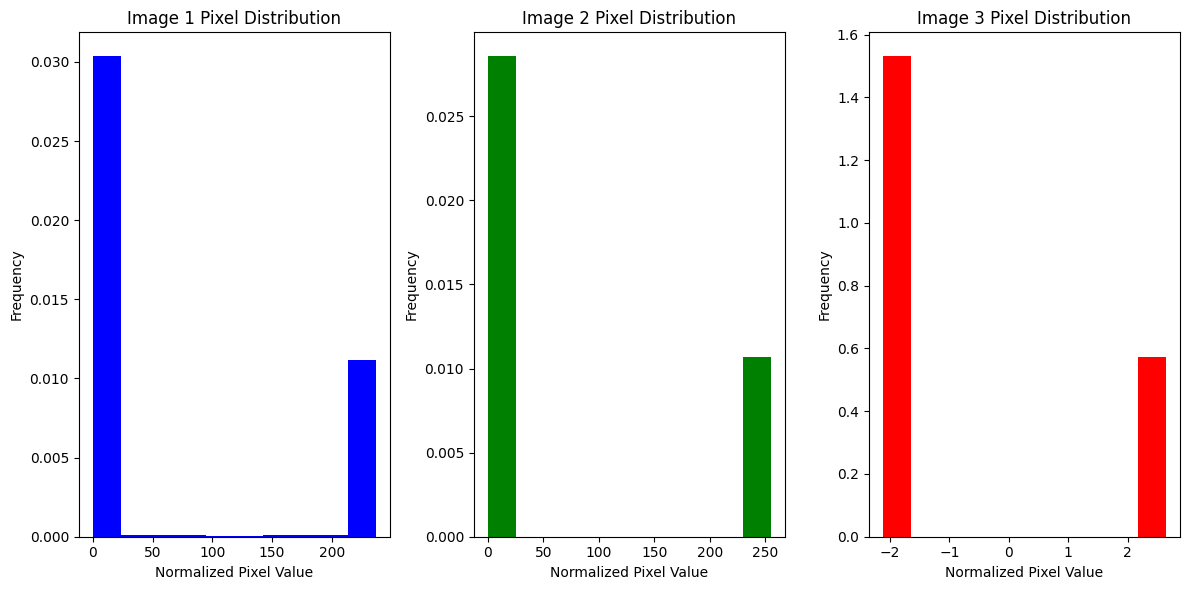

In [ ]:
# test load a single image
def load_img(path_img): #, path_mask
    images = listdir(path_img)
    images = [img for img in images if img.endswith(".png")]
    for image in images:
        img = cv2.imread(path_img + image, cv2.IMREAD_COLOR) #RGB or BGR ?
        break
    return img

# resize image
def resize_img(img, size_y, size_x, threshold):
    img = cv2.resize(img, (size_y, size_x))
    img[img<threshold] = 0 #pixel value {0, 255}
    img[img>threshold] = 255
    # mask_resized[resized+key] = mask

    return img

# transform image
def preprocess_img(img, preprocessing_fn): #fn holds for function
    preprocessed = albu.Lambda(image=preprocessing_fn)(image=img)
    return preprocessed['image']
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, encoder_weights)
img_raw = load_img(PATH_TR_MASK_AUG_RAW)
img_resized = resize_img(img_raw, SIZE_Y, SIZE_X, 120)
img_preprocessed = preprocess_img(img_resized, preprocessing_fn)
# import cv2
# import matplotlib.pyplot as plt

# # Replace 'path_to_image1.jpg', 'path_to_image2.jpg', 'path_to_image3.jpg' with the actual paths to your images
# image1_path = 'path_to_image1.jpg'
# image2_path = 'path_to_image2.jpg'
# image3_path = 'path_to_image3.jpg'

# # Load images
# image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE) / 255.0
# image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE) / 255.0
# image3 = cv2.imread(image3_path, cv2.IMREAD_GRAYSCALE) / 255.0

# Flatten the images to 1D arrays
pixel_values1 = img_raw.ravel()
pixel_values2 = img_resized.ravel()
pixel_values3 = img_preprocessed.ravel()

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
# plt.hist(pixel_values1, bins=100, range=(0, 1), density=True, color='blue', alpha=0.75)
plt.hist(pixel_values1, density=True, color='blue')
plt.title('Image 1 Pixel Distribution')
plt.xlabel('Normalized Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
# plt.hist(pixel_values2, bins=100, range=(0, 1), density=True, color='green', alpha=0.75)
plt.hist(pixel_values2, density=True, color='green')
plt.title('Image 2 Pixel Distribution')
plt.xlabel('Normalized Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
# plt.hist(pixel_values3, bins=100, range=(0, 1), density=True, color='red', alpha=0.75)
plt.hist(pixel_values3, density=True, color='red')
plt.title('Image 3 Pixel Distribution')
plt.xlabel('Normalized Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
image = load_img(PATH_TR_IMG_AUG_RAW)
mask = cv2.cvtColor(resize_img(load_img(PATH_TR_MASK_AUG_RAW), 400, 400, 1), cv2.COLOR_BGR2GRAY)
print(image.shape, mask.shape)

(400, 400, 3) (400, 400)


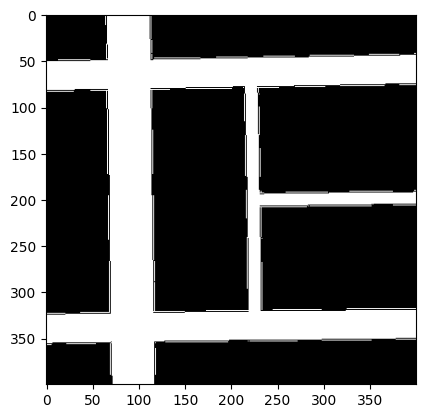

In [ ]:
plt.imshow(mask, cmap='gray')

(400, 400)


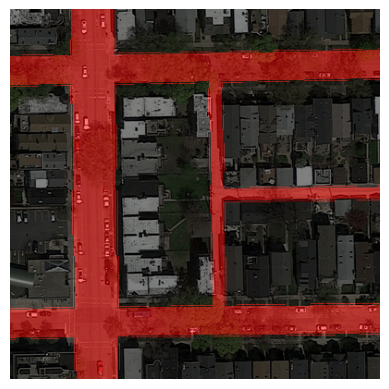

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Replace 'path_to_image.jpg' and 'path_to_mask.jpg' with the actual paths to your images
# image_path = 'path_to_image.jpg'
# mask_path = 'path_to_mask.jpg'

# Load images
# image = cv2.imread(image_path)
# mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert mask to 3 channels (assuming it's a single-channel mask)
# mask_colored = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Set the transparency level (alpha) for the mask (adjust as needed)
alpha = 0.5

# Create a semi-transparent red mask (BGR format)
red_mask = np.zeros_like(image)
print(mask.shape)
for (i,j), value in np.ndenumerate(mask):
    if value == 255:
        red_mask[i,j] = [0, 0, 255]
    # print(i,j, value)
    # break
# plt.imshow(red_mask)
# red_mask[:, :] = [0, 0, 255]
# red_mask[mask[:,:]==255]

# Blend the original image and the red mask using addWeighted
result = cv2.addWeighted(image, 1 - alpha, red_mask, alpha, 0)

# Apply the original mask as a transparency mask
# result = cv2.addWeighted(result, 1, mask, 0.5, 0)

# Display the result using matplotlib
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
image = load_img(PATH_TR_IMG_AUG_RAW)
image_bw = cv2.cvtColor(cv2.resize(image, (800, 800)), cv2.COLOR_BGR2GRAY)
contrast = image_bw.std() #49.22437388796795 (400x400), 46.67582364468852 (416x416), 46.66738046702053 (608x608), 46.368275989176844 (800x800)
print(contrast)

46.368275989176844


In [ ]:
PATH_TEST_IMG = "./data/test_set_images/test_10/" #57.62231155513464 (test_2)
image = load_img(PATH_TEST_IMG)
image_bw = cv2.cvtColor(cv2.resize(image, (608, 608)), cv2.COLOR_BGR2GRAY)
contrast = image_bw.std() #49.22437388796795 (400x400), 46.67582364468852 (416x416), 46.66738046702053 (608x608), 46.368275989176844 (800x800)
print(contrast)

44.706151544347


## test image deformation

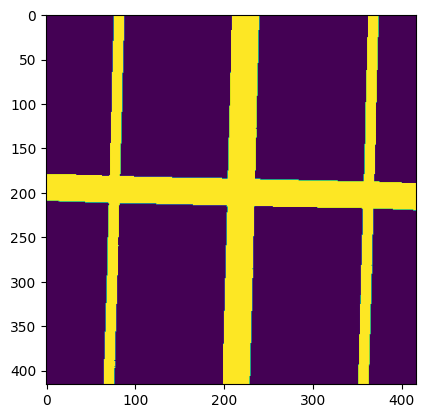

In [ ]:
plt.imshow(train_mask['180_h_r_satImage_001.png'])

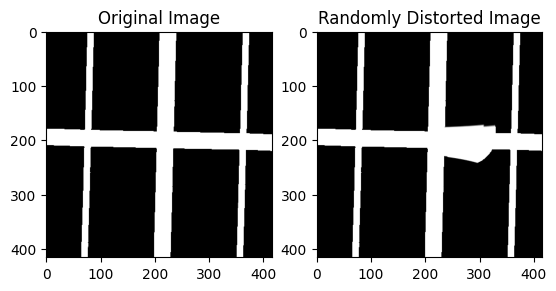

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import random

def random_distortion(image, num_points=5, max_radius=60, max_power=2, max_attempts=100):
        height, width = image.shape

        distorted = np.copy(image)  # Create a copy of the original image

        # for _ in range(num_points):
            # Randomly choose a non-black pixel for distortion
        for _ in range(max_attempts):
            center = (random.randint(0, width - 1), random.randint(0, height - 1))
            if 0 <= center[0] < width and 0 <= center[1] < height and image[center[1], center[0]] != 0:
                break
        # else:
        #     # If no suitable pixel is found, skip this iteration
        #     continue

        # Randomly choose the radius and power
        radius = random.uniform(40, max_radius)
        max_distance = max(height, width) / 2.0  # Max possible distance from the center
        power = random.uniform(1.5, max_power)

        map_y = np.zeros((height, width), dtype=np.float32)
        map_x = np.zeros((height, width), dtype=np.float32)

        # create index map
        for i in range(height):
            for j in range(width):
                map_y[i][j] = i
                map_x[i][j] = j

        # deform around the randomly chosen point
        for i in range(-int(radius), int(radius)):
            for j in range(-int(radius), int(radius)):
                if 0 <= center[0] + j < width and 0 <= center[1] + i < height and i**2 + j**2 <= radius**2:
                    distance = np.sqrt((center[1] + i - height/2)**2 + (center[0] + j - width/2)**2)
                    strength = 1 - distance / max_distance  # Increase deformation strength away from the center

                    if i > 0:
                        map_y[center[1] + i][center[0] + j] = center[1] + strength * (i / radius)**power * radius
                    if i < 0:
                        map_y[center[1] + i][center[0] + j] = center[1] - strength * (-i / radius)**power * radius
                    if j > 0:
                        map_x[center[1] + i][center[0] + j] = center[0] + strength * (j / radius)**power * radius
                    if j < 0:
                        map_x[center[1] + i][center[0] + j] = center[0] - strength * (-j / radius)**power * radius

        warped = cv.remap(image, map_x, map_y, cv.INTER_LINEAR)
        distorted = cv.addWeighted(distorted, 1, warped, 1, 0)  # Add the warped image to the distorted image

        return distorted

# Read the grayscale image
# img = cv.imread('kit.jpg', cv.IMREAD_GRAYSCALE)

# Apply random distortion with multiple points and distance-based strength
distorted = random_distortion(train_mask['180_h_r_satImage_001.png'], num_points=5)

# Display the original and distorted images
plt.subplot(1, 2, 1)
plt.imshow(train_mask['180_h_r_satImage_001.png'], cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(distorted, cmap='gray')
plt.title("Randomly Distorted Image")

plt.show()

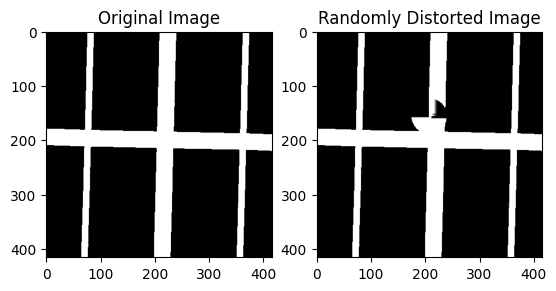

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import random

def random_distortion(image, num_points=5, max_radius=60, max_power=0.1, max_attempts=100):
    height, width = image.shape

    # Randomly choose a non-black pixel for distortion
    for _ in range(max_attempts):
        center = (random.randint(0, width - 1), random.randint(0, height - 1))
        if 0 <= center[0] < width and 0 <= center[1] < height and image[center[1], center[0]] != 0:
            break
    else:
        # If no suitable pixel is found, return the original image
        return image

    # Randomly choose the radius and power
    radius = random.uniform(20, max_radius)
    power = random.uniform(0.05, max_power)

    map_y = np.zeros((height, width), dtype=np.float32)
    map_x = np.zeros((height, width), dtype=np.float32)

    # create index map
    for i in range(height):
        for j in range(width):
            map_y[i][j] = i
            map_x[i][j] = j

    # deform around the randomly chosen point
    for i in range(-int(radius), int(radius)):
        for j in range(-int(radius), int(radius)):
            if 0 <= center[0] + j < width and 0 <= center[1] + i < height and i**2 + j**2 <= radius**2:
                # distance = np.sqrt((center[1] + i - height/2)**2 + (center[0] + j - width/2)**2)
                # distance = 1
                if i > 0:
                    map_y[center[1] + i][center[0] + j] = center[1] + (i / radius)**(power) * radius
                if i < 0:
                    map_y[center[1] + i][center[0] + j] = center[1] - (-i / radius)**(power) * radius
                if j > 0:
                    map_x[center[1] + i][center[0] + j] = center[0] + (j / radius)**(power) * radius
                if j < 0:
                    map_x[center[1] + i][center[0] + j] = center[0] - (-j / radius)**(power) * radius

    warped = cv.remap(image, map_x, map_y, cv.INTER_LINEAR) #cv.INTER_LINEAR
    return warped

# Read the grayscale image
# img = cv.imread('kit.jpg', cv.IMREAD_GRAYSCALE)

# Apply random distortion
distorted = random_distortion(train_mask['180_h_r_satImage_001.png'])

# Display the original and distorted images
plt.subplot(1, 2, 1)
plt.imshow(train_mask['180_h_r_satImage_001.png'], cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(distorted, cmap='gray')
plt.title("Randomly Distorted Image")

plt.show()

In [ ]:
plt.hist(distorted.ravel(), 255, [0,255])

In [ ]:
# add pertubation
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import random

def random_distortion(image, max_radius=10, max_power=1.5): #num_points=5?
    height, width = image.shape

    # Find all non-black pixels
    non_black_pixels = np.column_stack(np.where(np.any(image != [0], axis=-1)))

    if len(non_black_pixels) == 0:
        return image  # No non-black pixels found, return the original image

    # Randomly choose a non-black pixel for distortion
    center = tuple(random.choice(non_black_pixels))

    # # Randomly choose a non-black pixel for distortion
    # for _ in range(max_attempts):
    #     center = (random.randint(0, width - 1), random.randint(0, height - 1))
    #     if any(image[center[1], center[0]] != [0, 0, 0]):
    #         break
    # else:
    #     # If no non-black pixel is found, return the original image
    #     return image
    print(center)

    # Randomly choose the radius and power
    radius = random.uniform(5, max_radius)
    power = random.uniform(0.5, max_power)

    map_y = np.zeros((height, width), dtype=np.float32)
    map_x = np.zeros((height, width), dtype=np.float32)

    # create index map
    for i in range(height):
        for j in range(width):
            map_y[i][j] = i
            map_x[i][j] = j

    # deform around the randomly chosen point
    for i in range(-int(radius), int(radius)):
        for j in range(-int(radius), int(radius)):
            if i**2 + j**2 > radius**2:
                continue

            if i > 0:
                map_y[center[1] + i][center[0] + j] = center[1] + (i / radius)**power * radius
            if i < 0:
                map_y[center[1] + i][center[0] + j] = center[1] - (-i / radius)**power * radius
            if j > 0:
                map_x[center[1] + i][center[0] + j] = center[0] + (j / radius)**power * radius
            if j < 0:
                map_x[center[1] + i][center[0] + j] = center[0] - (-j / radius)**power * radius

    warped = cv.remap(image, map_x, map_y, cv.INTER_LINEAR)
    return warped

# Read the image
# img = cv.imread('kit.jpg')

# Apply random distortion
distorted = random_distortion(train_mask['180_h_r_satImage_001.png'])

# Display the original and distorted images
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(train_mask['180_h_r_satImage_001.png'], cv.IMREAD_GRAYSCALE))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(distorted, cv.IMREAD_GRAYSCALE))
plt.title("Randomly Distorted Image")

plt.show()

(327,)


IndexError: ignored

In [ ]:
# Tensor dataset (w and w/o preprocessing)
train_dataset = TensorDataset(train_img, train_mask)

In [ ]:
# model definition

In [ ]:
# model training
# learning rate decreased at each plateau
# iterative refinement (output is the new input)

## patch test

In [ ]:
# load first image and first patch
# path_first_img = './data/training/images/satImage_001.png'
# path_first_mask = './data/training/groundtruth/satImage_001.png'
# first_img = cv2.imread(path_first_img, cv2.IMREAD_COLOR)
# first_mask = cv2.imread(path_first_mask, cv2.IMREAD_GRAYSCALE)
# # imshow
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(first_img)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(first_mask)
# plt.axis('off')

# plt.show()
# resize mask to 418x418 and value between 0.0 and 1.0
# first_mask_r = np.float32(cv2.resize(first_mask, (418, 418))) / 255.
# compute average over 11x11 patches
threshold =  0.25
float_avg = {}
binary = []
patch_size = 11
height, width = first_mask_r.shape
for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            # Extract the patch
            patch = first_mask_r[y:y + patch_size, x:x + patch_size]

            # Calculate the average of the patch
            patch_average = np.mean(patch)
            float_avg[str(y)+"_"+str(x)] = patch_average
            if (patch_average > threshold):
                binary.append(1)
            else:
                binary.append(0)
            # Fill the corresponding region in the result image with the average value
            # result_image[y:y + patch_size, x:x + patch_size] = patch_average

# return result_image
# print(float_avg)
# resize mask to 608x608
first_mask_r_big = np.float32(cv2.resize(first_mask, (608, 608))) / 255.
float_avg_big = {}
binary_big = []
patch_size_big = 16
height, width = first_mask_r_big.shape
for y in range(0, height, patch_size_big):
        for x in range(0, width, patch_size_big):
            # Extract the patch
            patch = first_mask_r_big[y:y + patch_size_big, x:x + patch_size_big]

            # Calculate the average of the patch
            patch_average = np.mean(patch)
            float_avg_big[str(y)+"_"+str(x)] = patch_average
            if (patch_average > threshold):
                binary_big.append(1)
            else:
                binary_big.append(0)
# compute average over 16x16 patches
# threshold 0.25
# compare

In [ ]:
if binary == binary_big:
    print('equal')
else:
   print('not equal')

equal


In [ ]:
print(float_avg_big)

{'0_0': 0.0, '0_16': 0.0, '0_32': 0.0, '0_48': 0.0, '0_64': 0.0, '0_80': 0.07320772, '0_96': 0.9221661, '0_112': 0.034987748, '0_128': 0.0, '0_144': 0.0, '0_160': 0.0, '0_176': 0.0, '0_192': 0.0, '0_208': 0.0, '0_224': 0.0, '0_240': 0.0, '0_256': 0.0, '0_272': 0.00094975496, '0_288': 0.80689347, '0_304': 0.9294118, '0_320': 0.8832721, '0_336': 0.005147059, '0_352': 0.0, '0_368': 0.0, '0_384': 0.0, '0_400': 0.0, '0_416': 0.0, '0_432': 0.0, '0_448': 0.0, '0_464': 0.0, '0_480': 0.0, '0_496': 0.0017616423, '0_512': 0.87290144, '0_528': 0.1612592, '0_544': 0.0, '0_560': 0.0, '0_576': 0.0, '0_592': 0.0, '16_0': 0.0, '16_16': 0.0, '16_32': 0.0, '16_48': 0.0, '16_64': 0.0, '16_80': 0.05013787, '16_96': 0.9259498, '16_112': 0.059696693, '16_128': 0.0, '16_144': 0.0, '16_160': 0.0, '16_176': 0.0, '16_192': 0.0, '16_208': 0.0, '16_224': 0.0, '16_240': 0.0, '16_256': 0.0, '16_272': 0.00022977943, '16_288': 0.7794884, '16_304': 0.9294118, '16_320': 0.9029259, '16_336': 0.006219363, '16_352': 0.0, '

In [ ]:
print(float_avg)

{'0_0': 0.0, '0_11': 0.0, '0_22': 0.0, '0_33': 0.0, '0_44': 0.0, '0_55': 0.07574137, '0_66': 0.92224926, '0_77': 0.03513207, '0_88': 0.0, '0_99': 0.0, '0_110': 0.0, '0_121': 0.0, '0_132': 0.0, '0_143': 0.0, '0_154': 0.0, '0_165': 0.0, '0_176': 0.0, '0_187': 0.00064819324, '0_198': 0.80923676, '0_209': 0.9294118, '0_220': 0.88565874, '0_231': 0.0012315672, '0_242': 0.0, '0_253': 0.0, '0_264': 0.0, '0_275': 0.0, '0_286': 0.0, '0_297': 0.0, '0_308': 0.0, '0_319': 0.0, '0_330': 0.0, '0_341': 0.0012963865, '0_352': 0.8725005, '0_363': 0.16003889, '0_374': 0.0, '0_385': 0.0, '0_396': 0.0, '0_407': 0.0, '11_0': 0.0, '11_11': 0.0, '11_22': 0.0, '11_33': 0.0, '11_44': 0.0, '11_55': 0.049781237, '11_66': 0.9262033, '11_77': 0.06002269, '11_88': 0.0, '11_99': 0.0, '11_110': 0.0, '11_121': 0.0, '11_132': 0.0, '11_143': 0.0, '11_154': 0.0, '11_165': 0.0, '11_176': 0.0, '11_187': 0.0, '11_198': 0.78220713, '11_209': 0.9294118, '11_220': 0.9076974, '11_231': 0.0005185546, '11_242': 0.0, '11_253': 0.0

## patch test threshold

In [ ]:
# load first image and first patch
path_first_img = './data/training/images/satImage_025.png'
path_first_mask = './data/training/groundtruth/satImage_025.png'
first_img = cv2.imread(path_first_img, cv2.IMREAD_COLOR)
first_mask = cv2.imread(path_first_mask, cv2.IMREAD_GRAYSCALE)
# # imshow
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(first_img)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(first_mask)
# plt.axis('off')

# plt.show()
# resize mask to 418x418 and value between 0.0 and 1.0
first_mask_r = cv2.resize(first_mask, (400, 400))
# compute average over 11x11 patches
thr = 120
first_mask_r[first_mask_r<thr] = 0
first_mask_r[first_mask_r>thr] = 1
threshold =  0.25
float_avg = {}
binary = []
patch_size = 11
height, width = first_mask_r.shape
for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            # Extract the patch
            patch = first_mask_r[y:y + patch_size, x:x + patch_size]

            # Calculate the average of the patch
            patch_average = np.mean(patch)
            float_avg[str(y)+"_"+str(x)] = patch_average
            if (patch_average > threshold):
                binary.append(1)
            else:
                binary.append(0)
            # Fill the corresponding region in the result image with the average value
            # result_image[y:y + patch_size, x:x + patch_size] = patch_average

# return result_image
# print(float_avg)
# resize mask to 608x608 (456x456, 532x532)
first_mask_r_big = cv2.resize(first_mask, (400*38, 400*38))
first_mask_r_big[first_mask_r_big<thr] = 0
first_mask_r_big[first_mask_r_big>thr] = 1
print(first_mask_r_big.shape)
# float_avg_big = {}
binary_big = []
patch_size_big = 400 # 16, 12
height, width = first_mask_r_big.shape
for y in range(0, height, patch_size_big):
        for x in range(0, width, patch_size_big):
            # Extract the patch
            patch = first_mask_r_big[y:y + patch_size_big, x:x + patch_size_big]

            # Calculate the average of the patch
            patch_average = np.mean(patch)
            # float_avg_big[str(y)+"_"+str(x)] = patch_average
            if (patch_average > threshold):
                binary_big.append(1)
            else:
                binary_big.append(0)
# compute average over 16x16 patches
# threshold 0.25
# compare

In [ ]:
if binary == binary_big:
    print('equal')
else:
   print('not equal')

not equal


In [ ]:
not_equal = 0
equal = 0
for i, bin in enumerate(binary):
    if (bin == binary_big[i]):
        equal += 1
    else:
        not_equal += 1

In [ ]:
print(not_equal, equal) # 17 1427 (for 608x608) / 26 1418 (for 456x456) / 11 1433 (532x532)

506 863


## patch test from mask

(-0.5, 15199.5, 15199.5, -0.5)

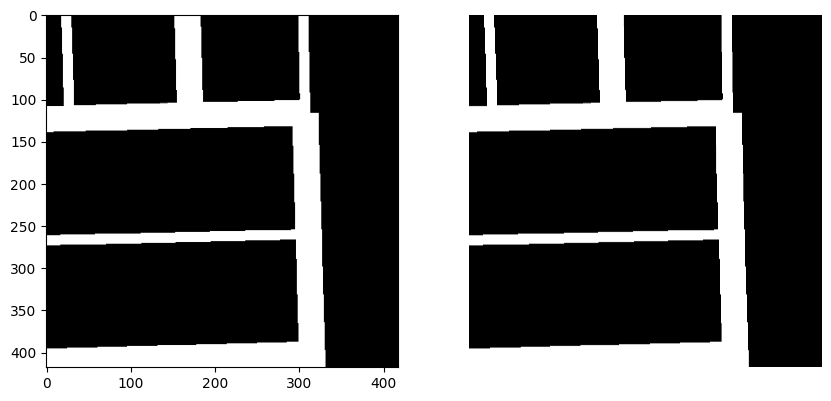

In [ ]:
# load first image and first patch
path_first_img = './data/training/images/satImage_005.png'
path_first_mask = './data/training/groundtruth/satImage_005.png'
first_img = cv2.imread(path_first_img, cv2.IMREAD_COLOR)
first_mask = cv2.imread(path_first_mask, cv2.IMREAD_GRAYSCALE)
# imshow
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(first_img)
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(first_mask)
# plt.axis('off')

# plt.show()
# resize mask to 418x418 and value between 0.0 and 1.0
first_mask_r = cv2.resize(first_mask, (418, 418))
# plt.imshow(first_mask_r)

# compute average over 11x11 patches
thr = 120
first_mask_r[first_mask_r<thr] = 0
first_mask_r[first_mask_r>thr] = 255
# plt.hist(first_mask_r.ravel(), 2,[0,2])

# plt.imshow(first_mask_r)
threshold =  0.25*255
float_avg = {}
binary = []
patch_size = 11
height, width = first_mask_r.shape
for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            # Extract the patch
            patch = first_mask_r[y:y + patch_size, x:x + patch_size]

            # Calculate the average of the patch
            patch_average = np.mean(patch)
            float_avg[str(y)+"_"+str(x)] = patch_average
            if (patch_average > threshold):
                binary.append(1)
            else:
                binary.append(0)
            # Fill the corresponding region in the result image with the average value
            # result_image[y:y + patch_size, x:x + patch_size] = patch_average

# return result_image
# print(float_avg)
# resize mask to 608x608 (456x456, 532x532)
# first_mask_r_bis = cv2.resize(first_mask, (418, 418))
# thr_bis = 0.5
first_mask_r_big = cv2.resize(first_mask_r, (400*38, 400*38), interpolation = cv2.INTER_NEAREST) #interpolation = cv2.INTER_NEAREST
first_mask_r_big[first_mask_r_big<thr] = 0
first_mask_r_big[first_mask_r_big>thr] = 255
float_avg_big = {}
binary_big = []
patch_size_big = 400 # 16, 12, 22
height, width = first_mask_r_big.shape
for y in range(0, height, patch_size_big):
        for x in range(0, width, patch_size_big):
            # Extract the patch
            patch = first_mask_r_big[y:y + patch_size_big, x:x + patch_size_big]

            # Calculate the average of the patch
            patch_average = np.mean(patch)
            float_avg_big[str(y)+"_"+str(x)] = patch_average
            if (patch_average > threshold):
                binary_big.append(1)
            else:
                binary_big.append(0)
# compute average over 16x16 patches
# threshold 0.25
# compare

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(first_mask_r, cmap='gray')
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(first_mask_r_big, cmap='gray')
plt.axis('off')

# plt.show()

In [ ]:
print(first_mask_r_big.shape)

(15200, 15200)


In [ ]:
not_equal = 0
equal = 0
for i, bin in enumerate(binary):
    if (bin == binary_big[i]):
        equal += 1
    else:
        not_equal += 1

In [ ]:
print(not_equal, equal) #22 1422 (linear interpolation), 23 1421 (inter area), 12 1432 (nearest), 2x size => 0 1444 (nearest)

0 1444


(array([561610.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

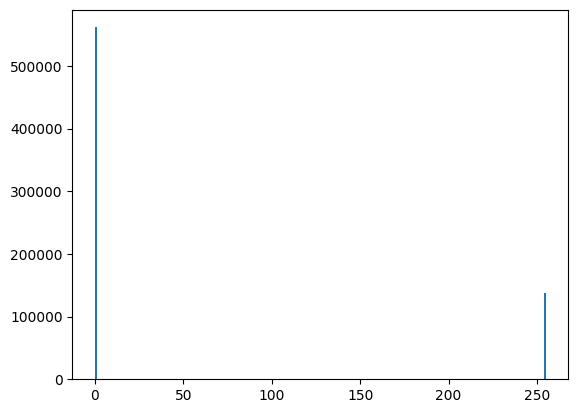

In [ ]:
plt.hist(first_mask_r_big.ravel(), 255,[0,255])

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(binary, binary_big)
print(f1) #0.9798270893371758 (nearest), 0.9661266568483062

0.9661266568483062


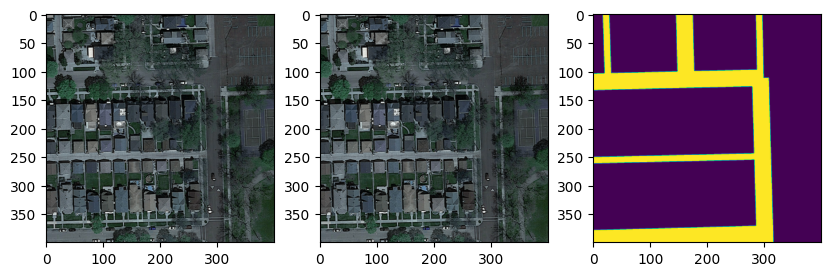

In [ ]:
path_first_img = './data/training/images/satImage_005.png'
path_first_mask = './data/training/groundtruth/satImage_005.png'
first_img = cv2.imread(path_first_img, cv2.IMREAD_COLOR) #cv2.COLOR_BGR2RGB
first_mask = cv2.imread(path_first_mask, cv2.IMREAD_GRAYSCALE)
first_img_bis = cv2.imread(path_first_img, cv2.COLOR_BGR2RGB) #cv2.COLOR_BGR2RGB

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(first_img)
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(first_img_bis)
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(first_mask)
# plt.axis('off')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Example lists (replace these with your actual ground truth and predicted lists)
ground_truth = [0, 1, 1, 0, 1, 0, 1, 1, 0]
predictions = [0, 1, 1, 0, 0, 1, 1, 1, 0]

# Calculate F1 score
f1 = f1_score(ground_truth, predictions)

print("F1 Score:", f1)

F1 Score: 0.8000000000000002


In [ ]:
PATH_IMG_TRAIN = "./data/training/images/"
PATH_MASK_TRAIN = "./data/training/groundtruth/"

In [ ]:
#load and preprocess data
#reshape to 384x384? => 5 layers => has to be divisible by 2^5
SIZE_X = 416 #384
SIZE_Y = 416 #384
MASK_THRESHOLD = 120

## Data augmentation

In [ ]:
import sys
sys.path.append('./utils/')
from data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset

# Create folders for data augmentation
%mkdir data/data_train_augmented
%mkdir data/data_train_augmented/images/
%mkdir data/data_train_augmented/masks/
%mkdir data/data_train_augmented/raw/
%mkdir data/data_train_augmented/raw/images/
%mkdir data/data_train_augmented/raw/masks/
%mkdir data/data_validation
%mkdir data/data_validation/images/
%mkdir data/data_validation/masks/
%mkdir data/data_validation/raw/
%mkdir data/data_validation/raw/images/
%mkdir data/data_validation/raw/masks/

# Load images and masks from dataset
PATH_IMG_TRAIN = "./data/training/images/"
PATH_MASK_TRAIN = "./data/training/groundtruth/"
img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
key_list = list(img_train.keys())
key_list.sort()

# Split the images for training/validation (+ store)
training_ratio = 0.8
seed = 1
train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

MASK_THRESHOLD = 120
SIZE_X = 416 #divisible by 32
SIZE_Y = 416 #divisible by 32
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_VAL_IMG = "./data/data_validation/images/"
PATH_VAL_MASK = "./data/data_validation/masks/"

# Load validation images and resize
img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
keys_val = list(img_val_raw.keys())
resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

# Load training images, resize and augment using geometric transformation (+ store)
img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
keys_tr = list(img_tr_raw.keys())
resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

Images stored in ./data/data_train_augmented/raw/images/
Images stored in ./data/data_train_augmented/raw/masks/
Images stored in ./data/data_validation/raw/images/
Images stored in ./data/data_validation/raw/masks/
Images stored in ./data/data_validation/images/
Images stored in ./data/data_validation/masks/
Images stored in ./data/data_train_augmented/images/
Images stored in ./data/data_train_augmented/masks/


In [ ]:
def resize_augment_store_dataset(img_dict, mask_dict, keys, size_y, size_x, mask_threshold, path_img, path_mask, augment=False):
  """
    Resize, augment, and store a dataset of images and masks.

    Args:
    - img_dict (dict): Dictionary containing original images with keys.
    - mask_dict (dict): Dictionary containing corresponding masks with keys.
    - keys (list): List of keys representing the images and masks to be processed.
    - size_y (int): Target height of the resized images and masks.
    - size_x (int): Target width of the resized images and masks.
    - mask_threshold (int): Threshold value for binarizing masks.
    - path_img (str): Path to store the resized and augmented images.
    - path_mask (str): Path to store the resized and augmented masks.
    - augment (bool, optional): Flag indicating whether to perform data augmentation. Default is False.

    Returns:
    - None
    """
  img_resized = {}
  mask_resized = {}
  resized = "r_"
  for key in keys:
    img = cv2.resize(img_dict[key], (size_y, size_x))
    img_resized[resized+key] = img
    mask = cv2.resize(mask_dict[key], (size_y, size_x))
    mask[mask<mask_threshold] = 0 #pixel value {0, 255}
    mask[mask>mask_threshold] = 255
    mask_resized[resized+key] = mask

  if augment:
    # Data augmentation
    # Flip: horizontal and vertical
    h_flipped = "h_"
    v_flipped = "v_"
    aug_h = albu.HorizontalFlip(p=1)
    aug_v = albu.VerticalFlip(p=1)

    key_resized = list(img_resized.keys())
    for key in key_resized:
      h = aug_h(image=img_resized[key], mask=mask_resized[key])
      v = aug_v(image=img_resized[key], mask=mask_resized[key])
      img_resized[h_flipped+key] = h['image']
      mask_resized[h_flipped+key] = h['mask']
      img_resized[v_flipped+key] = v['image']
      mask_resized[v_flipped+key] = v['mask']

    # Rotation: 90°, 180°, 270°
    rot_90 = "90_"
    rot_180 = "180_"
    rot_270 = "270_"
    key_resized_flipped = list(img_resized.keys())
    for key in key_resized_flipped:
      rot90_img = np.rot90(img_resized[key])
      img_resized[rot_90+key] = rot90_img
      rot180_img = np.rot90(rot90_img)
      img_resized[rot_180+key] = rot180_img
      rot270_img = np.rot90(rot180_img)
      img_resized[rot_270+key] = rot270_img

      rot90_mask = np.rot90(mask_resized[key])
      mask_resized[rot_90+key] = rot90_mask
      rot180_mask = np.rot90(rot90_mask)
      mask_resized[rot_180+key] = rot180_mask
      rot270_mask = np.rot90(rot180_mask)
      mask_resized[rot_270+key] = rot270_mask

  store_images(img_resized, list(img_resized.keys()), path_img)
  store_images(mask_resized, list(mask_resized.keys()), path_mask)

In [ ]:
def store_images(img_dict, keys, output_path):
    """
    Store images from a dictionary in a specified directory with filenames represented by keys.

    Args:
    - img_dict (dict): Dictionary containing images with keys.
    - keys (list): List of keys representing the images to be stored.
    - output_path (str): The path to the directory where the images will be saved.

    Returns:
    - None
    """
    for key in keys:
        # Full path to save the image
        save_path = os.path.join(output_path, key)
        cv2.imwrite(save_path, img_dict[key])

    print(f"Images stored in {output_path}")

In [ ]:
def split_keys(keys, training_ratio=0.8, seed=1):
    """
    Split a list of keys into training and validation sets.

    Args:
    - keys (numpy.ndarray): Array containing keys to be split.
    - training_ratio (float, optional): The ratio of keys to be used for training. Default is 0.8 (80%).
    - seed (int, optional): Seed for reproducibility. Default is 1.

    Returns:
    - numpy.ndarray: Array containing keys for the training set.
    - numpy.ndarray: Array containing keys for the validation set.
    """
    np.random.seed(seed)
    num_keys = len(keys)

    # Create a random permutation of indices
    indices = np.random.permutation(num_keys)

    # Calculate the number of samples for the training set
    num_training = int(training_ratio * num_keys)

    # Split images and masks into training and validation sets
    train_indices = indices[:num_training]
    val_indices = indices[num_training:]
    train_keys, val_keys = keys[train_indices], keys[val_indices]
    return np.array(train_keys), np.array(val_keys)

In [ ]:
def load_img_training(path_img, path_mask):
    """
      Load training images and corresponding masks from specified directories.

      Args:
      - path_img (str): The path to the directory containing training images. Images should be in PNG format.
      - path_mask (str): The path to the directory containing corresponding masks for training images. Masks should be in PNG format and grayscale.

      Returns:
      - numpy.ndarray: An array containing training images loaded from the specified directory.
      - numpy.ndarray: An array containing corresponding masks for the training images loaded from the specified directory.
    """
    train_img = {}
    images = listdir(path_img)
    images = [img for img in images if img.endswith(".png")]

    for image in images:
        img = cv2.imread(path_img + image, cv2.IMREAD_COLOR)
        train_img[image] = img

    train_mask = {}
    masks = listdir(path_mask)
    masks = [img for img in masks if img.endswith(".png")]

    for mask in masks:
        img = cv2.imread(path_mask + mask, cv2.IMREAD_GRAYSCALE)
        train_mask[mask] = img

    return train_img, train_mask


In [ ]:
def resize_split_store_augmented_dataset(img_train, mask_train, size_y, size_x, mask_threshold, tr_ratio, seed, path_tr_img, path_tr_mask, path_val_img, path_val_mask):
  train_img = []
  for img in img_train:
    img = cv2.resize(np.uint8(img), (size_y, size_x))
    train_img.append(img)

  train_mask = []
  for mask in mask_train:
    mask = cv2.resize(np.uint8(mask), (size_y, size_x))
    mask[mask<mask_threshold] = 0 #pixel value {0, 255}
    mask[mask>mask_threshold] = 255
    train_mask.append(mask)

  tr_img, val_img, tr_masks, val_masks = split_data(np.copy(np.array(train_img)), np.copy(np.array(train_mask)), tr_ratio, seed)
  store_images(val_img, path_val_img)
  store_images(val_masks, path_val_mask)

  # Data augmentation
  # Horizontal and vertical flip
  aug = albu.HorizontalFlip(p=1)
  h_flipped = aug(image=tr_img, mask=tr_masks)
  aug = albu.VerticalFlip(p=1)
  v_flipped = aug(image=tr_img, mask=tr_masks)
  augmented_data = {
          'image': np.concatenate([np.copy(tr_img), h_flipped['image'], v_flipped['image']]),
          'mask': np.concatenate([np.copy(tr_masks), h_flipped['mask'], v_flipped['mask']])
  }

  # Rotation: 90°, 180°, 270°
  rotated_img = []
  for img in augmented_data['image']:
    rot90 = np.rot90(img)
    rot180 = np.rot90(rot90)
    rot270 = np.rot90(rot180)
    rotated_img.append(rot90)
    rotated_img.append(rot180)
    rotated_img.append(rot270)

  rotated_mask = []
  for img in augmented_data['mask']:
    rot90 = np.rot90(img)
    rot180 = np.rot90(rot90)
    rot270 = np.rot90(rot180)
    rotated_mask.append(rot90)
    rotated_mask.append(rot180)
    rotated_mask.append(rot270)
  augmented_data = {
          'image': np.concatenate([np.copy(tr_img), h_flipped['image'], v_flipped['image'], rotated_img]),
          'mask': np.concatenate([np.copy(tr_masks), h_flipped['mask'], v_flipped['mask'], rotated_mask])
  }

  store_images(augmented_data['image'], path_tr_img)
  store_images(augmented_data['mask'], path_tr_mask)

In [ ]:
# generator = torch.Generator().manual_seed(seed)
# train_dataset = TensorDataset(torch.LongTensor(img_train), torch.LongTensor(mask_train))
# tr, val = random_split(train_dataset, [training_ratio, 1-training_ratio], generator=generator)
# print(tr.dataset.tensors[1].size())
# print(val.dataset.tensors[1].size())
# tr_img, val_img, tr_masks, val_masks = split_data(img_train, mask_train, training_ratio, seed)

# store_images(tr_img, PATH_TR_IMG_AUG_RAW)
# store_images(tr_masks, PATH_TR_MASK_AUG_RAW)
# store_images(val_img, PATH_VAL_IMG_RAW)
# store_images(val_masks, PATH_VAL_MASK_RAW)

# resize_split_store_augmented_dataset(
#     np.copy(img_train), np.copy(mask_train), SIZE_Y, SIZE_X, MASK_THRESHOLD, training_ratio, seed,
#     PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, PATH_VAL_IMG, PATH_VAL_MASK)
# resize
# threshold
# split
# store validation
# data augmentation on training data
# - horizontal/vertical flip
# - random rotation (8)
# - random translation (4)
# - scaling (2)
# store training

In [ ]:
def store_images(images, output_path):
    """
    Store images in a specified directory with filenames containing increasing numbering.

    Args:
    - images (numpy.ndarray): Array containing images to be stored.
    - output_path (str): The path to the directory where the images will be saved.

    Returns:
    - None
    """

    # Iterate over the images and save them with increasing numbering
    for i, image in enumerate(images):
        # Construct the filename with an increasing number
        filename = f"image_{i + 1}.png"

        # Full path to save the image
        save_path = os.path.join(output_path, filename)

        # Save the image using OpenCV
        cv2.imwrite(save_path, image)

    print(f"Images stored in {output_path}")


In [ ]:
def split_data(images, masks, training_ratio=0.8, seed=1):
    """
    Split images and their respective masks into training and validation sets.

    Args:
    - images (numpy.ndarray): Array containing training images.
    - masks (numpy.ndarray): Array containing corresponding masks for training images.
    - training_ratio (float, optional): The ratio of data to be used for training. Default is 0.8 (80%).
    - seed (int, optional): Seed for reproducibility. Default is 1.

    Returns:
    - numpy.ndarray: Training images.
    - numpy.ndarray: Validation images.
    - numpy.ndarray: Training masks.
    - numpy.ndarray: Validation masks.
    """

    # Set the random seed for reproducibility
    np.random.seed(seed)

    # Get the number of samples
    num_samples = len(images)

    # Create a random permutation of indices
    indices = np.random.permutation(num_samples)

    # Calculate the number of samples for the training set
    num_training = int(training_ratio * num_samples)

    # Split indices into training and validation sets
    train_indices = indices[:num_training]
    val_indices = indices[num_training:]

    # Split images and masks into training and validation sets
    train_images, val_images = images[train_indices], images[val_indices]
    train_masks, val_masks = masks[train_indices], masks[val_indices]

    return np.copy(train_images), np.copy(val_images), np.copy(train_masks), np.copy(val_masks)

In [ ]:
from timm.layers.pos_embed_sincos import rot
tr_img = img_train[0:2]
tr_mask = mask_train[0:2]
print(tr_img.shape, tr_mask.shape)

# all_img = tr_img
# all_mask = tr_mask

aug = albu.HorizontalFlip(p=1)
h_flipped = aug(image=tr_img, mask=tr_mask)
aug = albu.VerticalFlip(p=1)
v_flipped = aug(image=tr_img, mask=tr_mask)
augmented_data = {
        'image': np.concatenate([tr_img, h_flipped['image'], v_flipped['image']]),
        'mask': np.concatenate([tr_mask, h_flipped['mask'], v_flipped['mask']])
}
print(len(augmented_data['image']))
rotated_img = []
for img in augmented_data['image']:
  rot90 = np.rot90(img)
  rot180 = np.rot90(rot90)
  rot270 = np.rot90(rot180)
  rotated_img.append(rot90)
  rotated_img.append(rot180)
  rotated_img.append(rot270)

rotated_mask = []
for img in augmented_data['mask']:
  rot90 = np.rot90(img)
  rot180 = np.rot90(rot90)
  rot270 = np.rot90(rot180)
  rotated_mask.append(rot90)
  rotated_mask.append(rot180)
  rotated_mask.append(rot270)
augmented_data = {
        'image': np.concatenate([tr_img, h_flipped['image'], v_flipped['image'], rotated_img]),
        'mask': np.concatenate([tr_mask, h_flipped['mask'], v_flipped['mask'], rotated_mask])
}
# aug = albu.Rotate(angle=90.0)
# rot_90 = aug(image=augmented_data['image'], mask=augmented_data['mask'])
# aug = albu.rotate(angle=180.0)
# rot_180 = aug(image=augmented_data['image'], mask=augmented_data['mask'])
# aug = albu.rotate(angle=270.0)
# rot_270 = aug(image=augmented_data['image'], mask=augmented_data['mask'])
# augmented_data = {
#         'image': np.concatenate([tr_img, h_flipped['image'], v_flipped['image'], rot_90['image'], rot_180['image'], rot_270['image']]),
#         'mask': np.concatenate([tr_mask, h_flipped['mask'], v_flipped['mask'], rot_90['mask'], rot_180['mask'], rot_270['mask']])
# }

print(len(augmented_data['image']))
# aug = albu.RandomRotate90(p=1)
# rand_rotation = aug(image=tr_img, mask=tr_mask)
# rotated = []
# angles = [90.0, 180.0, 270.0]
# for angle in angles:
#   aug = albu.rotate(angle=angle)
#   rot = aug(image=augmented_data['image'], mask=augmented_data['mask'])
# aug = A.VerticalFlip(p=1)

# augmented = aug(image=image, mask=mask)

# image_v_flipped = augmented['image']
# mask_v_flipped = augmented['mask']

(2, 400, 400, 3) (2, 400, 400)
6
24


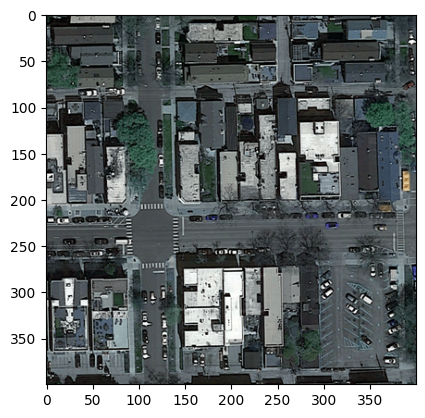

In [ ]:
plt.imshow(tr_img[2])

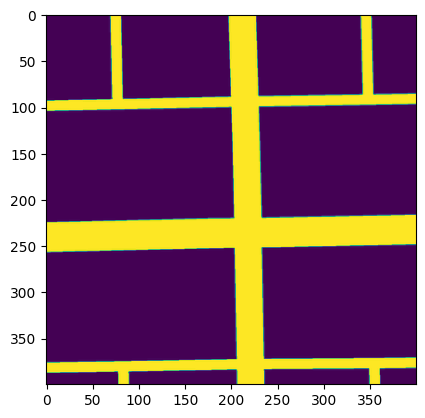

In [ ]:
plt.imshow(tr_masks[2])

In [ ]:
# def pre_transforms(image_size=224):
#     return [albu.Resize(image_size, image_size, p=1)]

def albumentations_transform()
def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result


def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

train_transforms = compose([
    resize_transforms(),
    hard_transforms(),
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

In [ ]:
def load_resize_img_train(path_img, path_mask, size_y, size_x, mask_threshold):
  train_img = []
  images = listdir(path_img)
  images = [img for img in images if img.endswith(".png")]
  for image in images:
    img = cv2.imread(path_img + image, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (size_y, size_x))
    img = img.astype(float) / 255 #value between 0 and 1
    train_img.append(img)

  train_mask = []
  masks = listdir(path_mask)
  masks = [img for img in masks if img.endswith(".png")]
  for mask in masks:
    mask = cv2.imread(path_mask + mask, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (size_y, size_x))
    mask[mask<mask_threshold] = 0 #value 0 or 1
    mask[mask>mask_threshold] = 1
    mask = mask[..., np.newaxis]
    train_mask.append(mask)

  train_img = np.array(train_img).transpose((0, 3, 1, 2))
  train_mask = np.array(train_mask)
  train_mask = train_mask.transpose((0, 3, 1, 2))
  return torch.FloatTensor(train_img), torch.BoolTensor(train_mask)

## Test on images pixels

In [ ]:
# PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
# X_train = torch.rand(708, 256, 3)
# X_train = X_train.permute(2, 0, 1)
# X_train.shape
# Convert each mask from HW to 1HW format for binary segmentation (expand the first dimension)


In [ ]:
print(np.count_nonzero(np.array(train_mask[0] == True))) #33887
print(np.count_nonzero(np.array(train_mask[0] == False)))#139169 => 139169+33887=416^2

33887
139169


## model Unet with Tomas example

In [ ]:
#load images
train_img, train_mask = load_resize_img_train(PATH_IMG_TRAIN, PATH_MASK_TRAIN, SIZE_X, SIZE_Y, MASK_THRESHOLD)
print(train_img.size(), train_mask.size())

torch.Size([100, 3, 416, 416]) torch.Size([100, 1, 416, 416])


In [ ]:
#dataset
# train_img, train_mask = train_img.cuda(), train_mask.cuda() # add this line to avoid: RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same (for torchsummary)
train_dataset = TensorDataset(train_img, train_mask)

In [ ]:
#split dataset
split_ratio = 0.8
seed = 1
generator = torch.Generator().manual_seed(seed)
tr, val = random_split(train_dataset, [split_ratio, 1-split_ratio], generator=generator)
tr_dataloader = DataLoader(tr, batch_size=8, shuffle=True) # create a dataloader => not really useful ?
val_dataloader = DataLoader(val, batch_size=1, shuffle=False) # create a dataloader => not really useful ?

In [ ]:
arch='Unet'
encoder_name='resnet34'
learning_rate=8e-5
in_channels=3
classes=1
activation='sigmoid'
DEVICE = 'cuda'
model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=classes, activation=activation)

In [ ]:
loss = smp.utils.losses.DiceLoss()
# tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, y_true, mode='binary', threshold=0.5)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    # smp.utils.metrics.Recall(),
    # smp.utils.metrics.Precision(),
    # smp.metrics.functional.iou_score(),
    # smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro") #micro => Sum true positive, false positive, false negative and true negative pixels over all images and all classes and then compute score.
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=learning_rate),
])
# CLASStorch.optim.Adam(
    # params, lr=0.001,
    # betas=(0.9, 0.999),
    # eps=1e-08,
    # weight_decay=0,
    # amsgrad=False, *,
    # foreach=None,
    # maximize=False,
    # capturable=False,
    # differentiable=False,
    # fused=None)
# eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [ ]:
class Fscore(base.Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return F.f_score(
            y_pr,
            y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [ ]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta**2) * tp + eps) / ((1 + beta**2) * tp + beta**2 * fn + fp + eps)

    return score

In [ ]:
class F1score(smp.utils.base.Metric):
  def __init__(self, threshold=0.5, activation=None, **kwargs):
      super().__init__(**kwargs)
      self.threshold = threshold
      self.activation = smp.base.modules.Activation(activation)
  # def forward(self, batch):
  def forward(self, y_pr, y_gt) #pr = predicted, gt = groundtruth
      # x, y_true = batch
      # mask_logits = self.forward(x)  #forward method returns predictions
      y_pr = self.activation(y_pr)
      # mask_probs = mask_logits.sigmoid()
      y_pr = (y_pr > 0.5).float() #=> value 0.0 or 1.0
      tp, fp, fn, tn = smp.metrics.get_stats(y_pr, y_gt, mode='binary', threshold=self.threshold)
      return smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
# def get_preprocessing(preprocessing_fn):
#     """Construct preprocessing transform

#     Args:
#         preprocessing_fn (callbale): data normalization function
#             (can be specific for each pretrained neural network)
#     Return:
#         transform: albumentations.Compose

#     """

#     _transform = [
#         albu.Lambda(image=preprocessing_fn),
#         albu.Lambda(image=to_tensor, mask=to_tensor),
#     ]
#     return albu.Compose(_transform)

In [ ]:
max_score = 0
dice_loss = []
iou = []
fscore = []
dice_loss_val = []
iou_val = []
fscore_val = []

for i in range(0, 80):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(tr_dataloader) #{'dice_loss': 0.17771973393180152, 'iou_score': 0.7441154169765386, 'fscore': 0.8307212482799183}
    valid_logs = valid_epoch.run(val_dataloader)
    dice_loss.append(train_logs["dice_loss"])
    iou.append(train_logs["iou_score"])
    fscore.append(train_logs["fscore"])
    dice_loss_val.append(valid_logs["dice_loss"])
    iou_val.append(valid_logs["iou_score"])
    fscore_val.append(valid_logs["fscore"])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 19/19 [00:00<00:00, 50.67it/s, dice_loss - 0.7112, iou_score - 0.1903, fscore - 0.315]
Model saved!

Epoch: 1
valid: 100%|██████████| 19/19 [00:00<00:00, 57.78it/s, dice_loss - 0.7031, iou_score - 0.2028, fscore - 0.3308]
Model saved!

Epoch: 2
valid: 100%|██████████| 19/19 [00:00<00:00, 50.15it/s, dice_loss - 0.6773, iou_score - 0.2322, fscore - 0.3666]
Model saved!

Epoch: 3
valid: 100%|██████████| 19/19 [00:00<00:00, 43.36it/s, dice_loss - 0.6736, iou_score - 0.2471, fscore - 0.3776]
Model saved!

Epoch: 4
valid: 100%|██████████| 19/19 [00:00<00:00, 53.55it/s, dice_loss - 0.6527, iou_score - 0.2869, fscore - 0.4193]
Model saved!

Epoch: 5
valid: 100%|██████████| 19/19 [00:00<00:00, 56.77it/s, dice_loss - 0.6403, iou_score - 0.3011, fscore - 0.4305]
Model saved!

Epoch: 6
valid: 100%|██████████| 19/19 [00:00<00:00, 57.43it/s, dice_loss - 0.6316, iou_score - 0.2827, fscore - 0.4192]

Epoch: 7
valid: 100%|██████████| 19/19 [00:00<00:00, 57.93it/s, dice

In [ ]:
# training:   dice_loss - 0.1562, iou_score - 0.9237, fscore - 0.9603   (40 epochs, batch=25, lr=1e-4)
# validation: dice_loss - 0.5637, iou_score - 0.3489, fscore - 0.4669   (40 epochs, batch=25, lr=1e-4)
# training:   dice_loss - 0.1503, iou_score - 0.9001, fscore - 0.9456   (40 epochs, batch=8, lr=1e-4)
# validation: dice_loss - 0.5547, iou_score - 0.3548, fscore - 0.4711   (40 epochs, batch=8, lr=1e-4)
# training:   dice_loss - 0.7633, iou_score - 0.04779, fscore - 0.09119 (40 epochs, batch=8, lr=1e-3)
# validation: dice_loss - 0.7803, iou_score - 0.04644, fscore - 0.08855 (40 epochs, batch=8, lr=1e-3)
# training:   dice_loss - 0.478, iou_score - 0.5007, fscore - 0.6649    (40 epochs, batch=8, lr=1e-5)
# validation: dice_loss - 0.6479, iou_score - 0.2668, fscore - 0.4021   (40 epochs, batch=8, lr=1e-5)
# training:   dice_loss - 0.1777, iou_score - 0.7441, fscore - 0.8307   (40 epochs, batch=8, lr=5e-5)
# validation: dice_loss - 0.5222, iou_score - 0.3841, fscore - 0.4798   (40 epochs, batch=8, lr=5e-5)
# training:   dice_loss - 0.08243, iou_score - 0.8979, fscore - 0.9461  (40 epochs, batch=8, lr=2e-4)
# validation: dice_loss - 0.5344, iou_score - 0.3664, fscore - 0.4726   (40 epochs, batch=8, lr=2e-4)
# training:   dice_loss - 0.2488, iou_score - 0.8646, fscore - 0.927    (80 epochs, batch=8, lr=8e-5)
# validation: dice_loss - 0.5916, iou_score - 0.338, fscore - 0.4564    (80 epochs, batch=8, lr=8e-5)

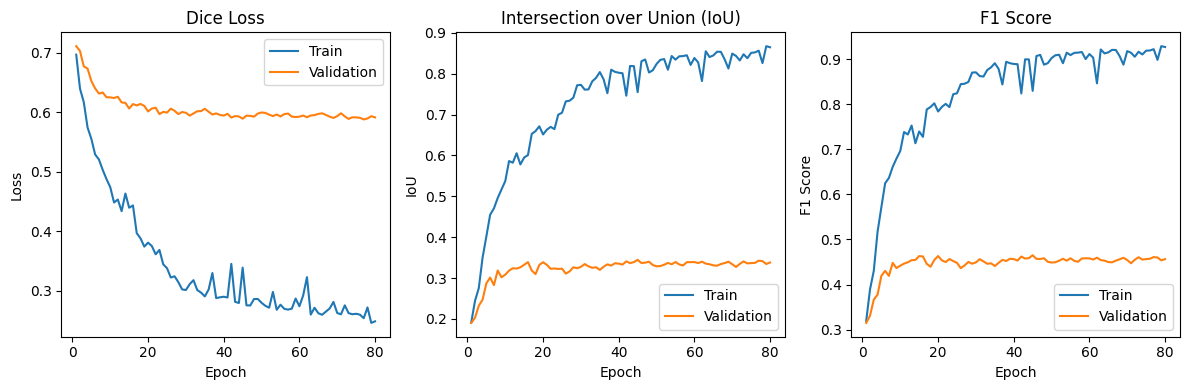

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a list of epochs (replace this with your actual epoch list)
epochs = list(range(1, len(dice_loss) + 1))

# Plotting dice_loss and dice_loss_val
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, dice_loss, label='Train')
plt.plot(epochs, dice_loss_val, label='Validation')
plt.title('Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting iou and iou_val
plt.subplot(1, 3, 2)
plt.plot(epochs, iou, label='Train')
plt.plot(epochs, iou_val, label='Validation')
plt.title('Intersection over Union (IoU)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

# Plotting fscore and fscore_val
plt.subplot(1, 3, 3)
plt.plot(epochs, fscore, label='Train')
plt.plot(epochs, fscore_val, label='Validation')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(train_logs)

{'dice_loss': 0.17771973393180152, 'iou_score': 0.7441154169765386, 'fscore': 0.8307212482799183}


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

In [ ]:
#model
model = smp.Unet(
    encoder_name = "resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights = "imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels = 3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes = 1,                      # model output channels (number of classes in your dataset) => 1 for binary segmentation
)

In [ ]:
# model = smp.create_model("Unet", encoder_name = "resnet34", encoder_weights = "imagenet", in_channels = 3, classes = 1,)

In [ ]:
# torchsummary.summary(model, input_size = (3, 416, 416), batch_size = -1)

In [ ]:
pl_module = pl.LightningModule()
pl_module.model = model

In [ ]:
# print(model.summary())

In [ ]:
# encoder_name: str='resnet34', encoder_depth: int=5, encoder_weights: Optional[str]='imagenet', decoder_use_batchnorm: bool=True, decoder_channels: List[int]=(256, 128, 64, 32, 16), decoder_attention_type: Optional[str]=None, in_channels: int=3, classes: int=1, activation: Optional[Union[str, callable]]=None, aux_params: Optional[dict]=None

In [ ]:
#compile
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

In [ ]:
# ???
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')

In [ ]:
n_cpu = os.cpu_count()
print(n_cpu)

2


In [ ]:
print(torch.cuda.device_count())

1


### Unet model with Lightning

In [ ]:
# Define LightningDataModule for PyTorch Lightning
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, batch_size=25):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

# Define LightningModule for PyTorch Lightning
class SegmentationModel(pl.LightningModule):
    def __init__(self, arch='Unet', encoder_name='resnet34', learning_rate=1e-3, in_channels=3, classes=1):
        super().__init__()
        # self.model = smp.Unet(encoder_name, in_channels=3, classes=1) #would be better to use create_model?
        self.model = smp.create_model(arch, encoder_name=encoder_name, in_channels=in_channels, classes=classes)
        self.learning_rate = learning_rate
        self.f1_score_vals = []
        # for image segmentation dice loss could be the best first choice
        self.loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True) #diceloss for highly unbalanced segmentations => from_logits – If True, assumes input is raw logits
        self.validation_step_outputs = []
        self.epoch_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        # loss = torch.nn.functional.cross_entropy(y_pred, y.squeeze(dim=1))
        # loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y.float()) #we should use Diceloss?
        loss = self.loss(y_pred, y) #why y.float()?
        self.log('loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) #make the optimizer changeable at initialization? feasible but with a dictionary to map each optimizer to a string

    def on_training_epoch_end(self, batch):
        x, y_true = batch
        mask_logits = self.forward(x)  #forward method returns predictions
        mask_probs = mask_logits.sigmoid() #change names to avoid confusion
        mask_pred = (mask_probs > 0.5).float() #=> value 0.0 or 1.0
        tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, y_true, mode='binary', threshold=0.5)
        f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro") #micro => Sum true positive, false positive, false negative and true negative pixels over all images and all classes and then compute score.
        self.f1_score_vals.append(f1)
        loss = self.loss(mask_logits, y_true)
        self.epoch_step_outputs.append(loss)
        metrics = {
            f"f1": f1,
            f"loss": loss,
        }
        self.log_dict(metrics, prog_bar=True)
        self.log('loss', loss, on_step=False, on_epoch=True)

    def validation_step(self, batch, batch_idx):
        x, y_true = batch
        mask_logits = self.forward(x)  #forward method returns predictions

        # y_pred = y_pred[y_pred<MASK_THRESHOLD] = 0 #value 0 or 1 # => make a function thresholding
        # y_pred = y_pred[y_pred>MASK_THRESHOLD] = 1
        mask_probs = mask_logits.sigmoid() #change names to avoid confusion
        mask_pred = (mask_probs > 0.5).float() #=> value 0.0 or 1.0
        # Move thresholding to GPU and convert to NumPy
        # y_true_cpu = y_true.int().view(-1).cpu().numpy()
        # y_pred_cpu = (y_pred > 0.5).int().view(-1).cpu().numpy()  # Adjust the threshold as needed
        # pred_mask_cpu = y_true.int().view(-1).cpu().numpy()
        # y_true_cpu = y_true.cpu()
        # pred_mask_cpu = pred_mask.cpu()
        # Compute F1 score
        # f1 = f1_score(y_true_cpu, pred_mask_cpu, average='binary', zero_division=1)
        # f1 = smp.utils.functional.f1()
        tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, y_true, mode='binary', threshold=0.5)
        # self.f1_score_vals.append(torch.FloatTensor(f1))
        f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro") #micro => Sum true positive, false positive, false negative and true negative pixels over all images and all classes and then compute score.
        self.f1_score_vals.append(f1)
        # Your validation loss
        # loss = self.criterion(y_pred, y_true)
        loss = self.loss(mask_logits, y_true)
        # return {"val_loss": loss, "val_f1": f1, "y_pred": y_pred_cpu, "y_true": y_true_cpu}
        self.validation_step_outputs.append(loss)
        # tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")
        # return {"val_loss": loss}

    # def on_validation_epoch_end(self, outputs, epoch):
    def on_validation_epoch_end(self):
        all_losses = torch.stack(self.validation_step_outputs)
        avg_loss = torch.stack([x for x in all_losses]).mean()
        all_f1 = torch.stack(self.f1_score_vals)
        avg_f1 = torch.stack([x for x in all_f1]).mean()

        self.log("val_loss", avg_loss, prog_bar=True)
        # self.log("all_losses", all_losses)
        self.validation_step_outputs.clear()
        self.log("val_f1", avg_f1, prog_bar=True)
        # self.log("all_f1", all_f1)
        self.f1_score_vals.clear()



In [ ]:
# Initialize LightningDataModule and LightningModule
data_module = SegmentationDataModule(tr, val, batch_size=25)
model = SegmentationModel()

# Initialize PyTorch Lightning Trainer
# trainer = pl.Trainer(max_epochs=1, gpus=1)  # Set max_epochs and gpus according to your setup or use torch.cuda.device_count()?
trainer = pl.Trainer(max_epochs=5, devices=1, accelerator="gpu")  # Set max_epochs and gpus according to your setup
# trainer = pl.Trainer(max_epochs=1)
# Train the model
returns = trainer.fit(model, datamodule=data_module) #2min20sec for 1 CPU?5min actually, 1 epoch, 100 / 17sec with 1 GPU
# f1_scores = trainer.logged_metrics['val_f1']

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | Unet     | 24.4 M
1 | loss  | DiceLoss | 0     
-----------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
print(model.f1_score_vals)

[]


In [ ]:
# torchsummary.summary(model, input_size = (3, 416, 416), batch_size = -1)

In [ ]:
print(returns)

None


In [ ]:
valid_returns = trainer.validate(model, datamodule=data_module) #verbose=False?
print(valid_returns)
# [{'val_loss': 0.9525445103645325}] we need a threshold (1 epoch) => [{'val_loss': 0.5862794518470764}] (10 epoch)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_f1           │  3.2191914215218276e-05   │
│         val_loss          │    0.9961224794387817     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.9961224794387817, 'val_f1': 3.2191914215218276e-05}]


In [ ]:
f1_scores = model.f1_score_vals
print(f1_scores)

[]


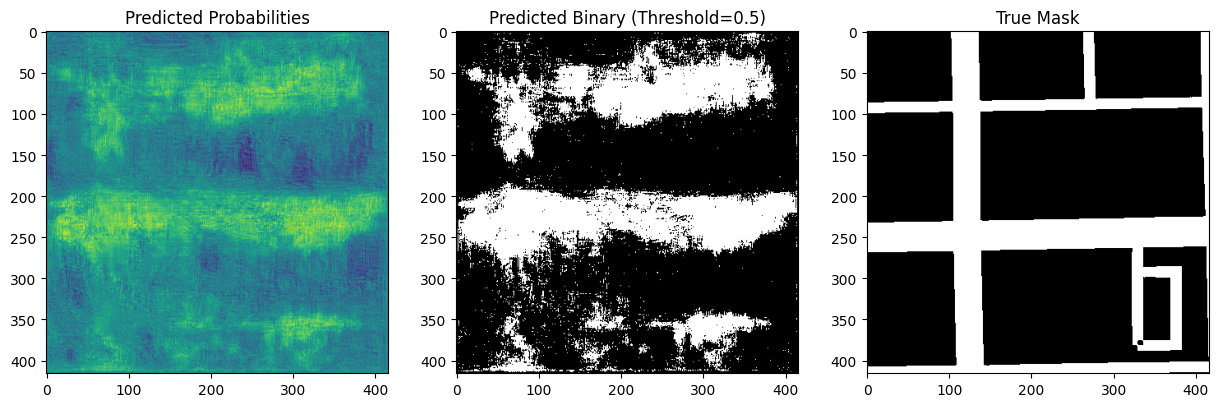

In [ ]:
import matplotlib.pyplot as plt

def visualize_mask(y_pred_prob, y_true, threshold=0.5):
    # Detach from the computation graph and move to CPU
    y_pred_prob_np = y_pred_prob.detach().cpu().numpy()
    y_true_np = y_true.detach().cpu().numpy()

    # Threshold probabilities to get binary predictions
    y_pred_binary = (y_pred_prob_np > threshold).astype(np.uint8)

    # Choose a random index
    # idx = np.random.randint(0, len(y_pred_prob_np))

    # Plot the predicted and true masks
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(y_pred_prob_np[0, 0], cmap='viridis')
    plt.title('Predicted Probabilities')

    plt.subplot(1, 3, 2)
    plt.imshow(y_pred_binary[0, 0], cmap='gray')
    plt.title(f'Predicted Binary (Threshold={threshold})')

    plt.subplot(1, 3, 3)
    plt.imshow(y_true_np[0, 0], cmap='gray')
    plt.title('True Mask')

    plt.show()


# def visualize_mask(y_pred, y_true):
#     # Convert tensors to numpy arrays (assuming they are on CPU)
#     # print(y_pred.size())
#     y_pred_np = y_pred.detach().cpu().numpy()
#     y_true_np = y_true.detach().cpu().numpy()

#     # Choose a random index
#     # print(y_pred_np.shape)
#     # print(len(y_pred_np))
#     # idx = random.sample(range(len(y_pred_np)), 1)
#     # print(idx)
#     # idx = random.randint(0, len(y_pred_np))

#     # Plot the predicted and true masks
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     # plt.imshow(y_pred_np[idx, 0], cmap='gray')
#     plt.imshow(y_pred_np[0, 0], cmap='gray')
#     plt.title('Predicted Mask')

#     plt.subplot(1, 2, 2)
#     # plt.imshow(y_true_np[idx, 0], cmap='gray')
#     plt.imshow(y_true_np[0, 0], cmap='gray')
#     plt.title('True Mask')

#     plt.show()

idx = random.randint(0, len(tr_dataloader))
# print(len(tr_dataloader))
# print(idx)
# Assuming you have your dataloader
# batch = tr_dataloader[idx]
for i, batch in enumerate(tr_dataloader):
    # Extract batch
    if (i == idx):
      x, y_true = batch

# Forward pass to get predictions
      y_pred = model(x)
      # print(y_pred)
      # print(y_pred.size())
      # print(y_pred.max())
    # Visualize a random example
      visualize_mask(y_pred, y_true)
      break
    # break  # Visualize only the first batch for simplicity

In [ ]:
test_img = []
path_img = "./data/test_set_images/test_1/"
imgs = listdir(path_img)
imgs = [img for img in imgs if img.endswith(".png")]
for img in imgs:
  img = cv2.imread(path_img + img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  # img = img[np.newaxis, ...]
  test_img.append(img)
  break
# print(test_img.shape)
test_img_torch = torch.FloatTensor(np.array(test_img).transpose((0, 3, 1, 2)))
# print(test_img.shape)
print(test_img_torch.size())

torch.Size([1, 3, 416, 416])


In [ ]:
#write mask prediction in pred directory
#list all files in directories
from pathlib import Path, PurePath

# Root directory
root_dir = Path("./data/test_set_images/")
root_dir_bis = PurePath("./data/test_set_images/")

# List of all .png files in the root directory and its subdirectories
file_list = root_dir.rglob('*.png')
# file_list = root_dir('*.png')
# print(len(file_list))
# print(PurePath(file_list))
path_strings = [(path.as_posix(), PurePath(path.as_posix()).stem + '.png') for path in file_list]
pred_dir = "./pred/"
# print(path_strings)
# print(dir(root_dir_bis))
# print(root_dir_bis.stem)
# filenames_with_extension = [path.as_posix().name for path in file_list]
# print(filenames_with_extension)
# print(len(path_strings))
# print(str(file_list))
# str_file = []
# for file in file_list:
#   str_file.append(file)
# print(str_file)
#for loop
for img_path, filename in path_strings:
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = img.astype(float) / 255 #value between 0 and 1
  img = img[np.newaxis, ...]
  # print(img.shape)
  img = torch.FloatTensor(np.array(img).transpose((0, 3, 1, 2)))
  prediction = model(img)
  prediction = prediction.sigmoid() #vaule between 0 and 1
  prediction = (prediction > 0.5).float() * 255.0
  prediction = cv2.resize(np.array(prediction[0, 0]), (400, 400))
  prediction[prediction < MASK_THRESHOLD] = 0
  prediction[prediction >= MASK_THRESHOLD] = 255.0
  cv2.imwrite(pred_dir + "pred_" + filename, prediction)
  break


In [ ]:
print(np.count_nonzero(prediction == 255)) #79933
print(np.count_nonzero(prediction == 0)) #80067 => 80067+79933=400^2

79933
80067


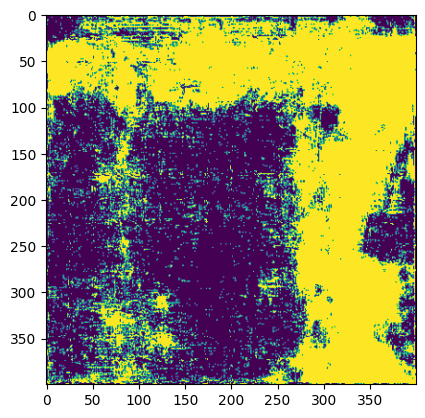

In [ ]:
plt.imshow(prediction)

In [ ]:
cv2.imwrite(pred_dir + "test.png", np.array(prediction[0, 0]))

True

In [ ]:
submission_filename = 'Unet_submission.csv'
image_filenames = []
# for i in range(1, 51):
for i in range(29, 51): ##
    image_filename = './pred_Unet/pred_test_' + '%.2d' % i + '.png'
    # print(image_filename)
    image_filenames.append(image_filename)
    break ##
masks_to_submission(submission_filename, *image_filenames) #edit => mask to submission ! there is an error


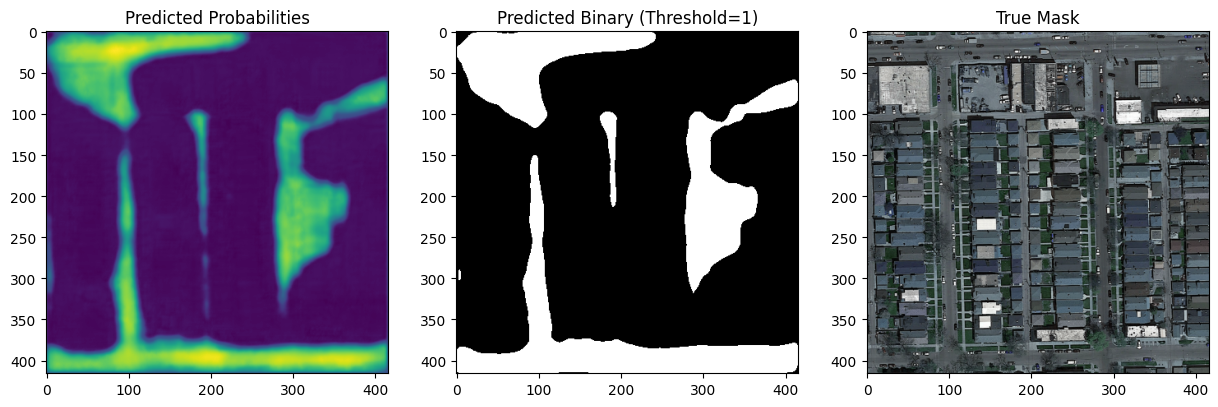

In [ ]:
y_pred_prob = model(test_img_torch)
y_pred_prob_np = y_pred_prob.detach().cpu().numpy()
# y_true_np = y_true.detach().cpu().numpy()
threshold = 1
# Threshold probabilities to get binary predictions
y_pred_binary = (y_pred_prob_np > threshold).astype(np.uint8)

# Choose a random index
# idx = np.random.randint(0, len(y_pred_prob_np))

# Plot the predicted and true masks
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(y_pred_prob_np[0, 0], cmap='viridis')
plt.title('Predicted Probabilities')

plt.subplot(1, 3, 2)
plt.imshow(y_pred_binary[0, 0], cmap='gray')
plt.title(f'Predicted Binary (Threshold={threshold})')

plt.subplot(1, 3, 3)
plt.imshow(test_img[0], cmap='viridis')
plt.title('True Mask')

plt.show()

In [ ]:
y_pred_400 = cv2.resize(y_pred_binary[0, 0], (400, 400))

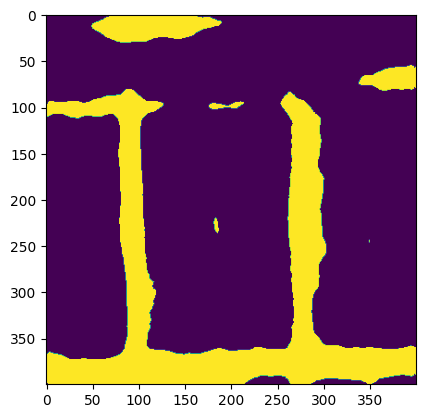

In [ ]:
plt.imshow(y_pred_400)

In [ ]:
print(np.count_nonzero(np.array(y_pred_400 == True))) #35096
print(np.count_nonzero(np.array(y_pred_400 == False)))#124904 => 124904+35096=400^2

35096
124904


In [ ]:
# import segmentation_models_pytorch as smp
# import pytorch_lightning as pl
# from torch.utils.data import DataLoader, random_split
# import torch
# import numpy as np

# Assume you have your data in numpy arrays X_train and y_train
# X_train = np.random.rand(100, 3, 256, 256)  # Example random data
# y_train = np.random.randint(0, 2, (100, 1, 256, 256))  # Example binary segmentation labels

# Convert data to PyTorch tensors
# X_train_tensor = torch.FloatTensor(X_train)
# y_train_tensor = torch.LongTensor(y_train)  # Assuming binary segmentation with classes 0 and 1

# Define a simple dataset
# dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
trainer = pl.Trainer(
    # gpus=1,
    max_epochs=1,
    max_steps=1,
)

trainer.fit(
    pl_module,
    train_dataloaders=tr_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
#load data

In [ ]:
#train model

## test pixels range

In [ ]:
train_mask[0].max()

tensor(237, device='cuda:0')

In [ ]:
threshold = 120
train_mask = []
path_mask = PATH_MASK_TRAIN
masks = listdir(path_mask)
masks = [img for img in masks if img.endswith(".png")]
for mask in masks:
  mask = cv2.imread(path_mask + mask, cv2.IMREAD_GRAYSCALE)
  mask[mask<threshold] = 0
  mask[mask>=threshold] = 1
  train_mask.append(mask)
  break
train_mask = np.array(train_mask)

In [ ]:
print(train_mask[0].max()) #237 /!\ not a real white (~gray)
print(train_mask[0].min()) #0

1
0


In [ ]:
print(train_mask[0].shape[0]*train_mask[0].shape[1]) #160'000 = 400*400

160000


In [ ]:
# count_237 = np.count_nonzero(train_mask[0] == 237) #26'336
# print(count_237)
count_1 = np.count_nonzero(train_mask[0] == 1) #(31'449 => after thresholding)
print(count_1)
count_0 = np.count_nonzero(train_mask[0] == 0) #124'011 (128'551 => after thresholding)
print(count_0)
print(count_1+count_0) #150'347 (160'000 => after thresholding)
# approximately 1:5 segmentation class ratio

31449
128551
160000


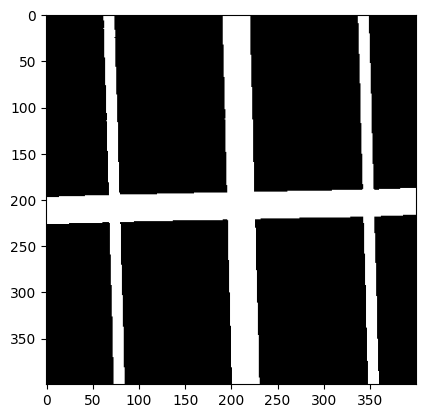

In [ ]:
plt.imshow(train_mask[0], cmap='gray')

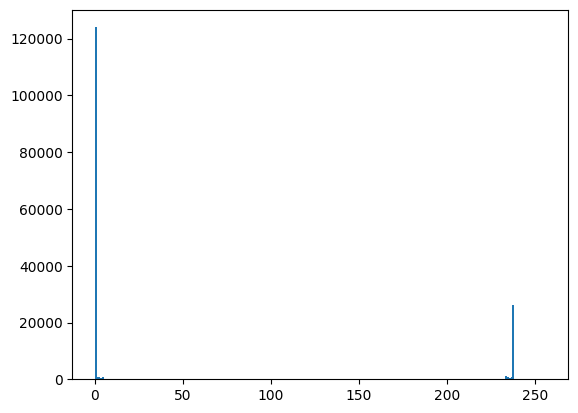

In [ ]:
plt.hist(train_mask[0].ravel(), 256,[0,256])
plt.show()

In [ ]:
train_mask_big = []
path_mask = PATH_MASK_TRAIN
masks = listdir(path_mask)
masks = [img for img in masks if img.endswith(".png")]
for mask in masks:
  mask = cv2.imread(path_mask + mask, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (1028, 1028))
  train_mask_big.append(mask)
  break
train_mask_big = np.array(train_mask_big)
print(train_mask_big.shape)

(1, 1028, 1028)


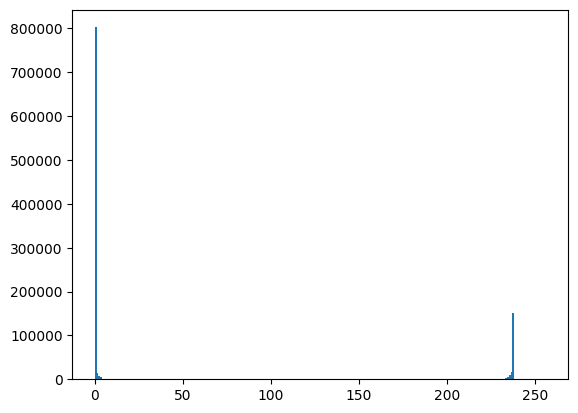

In [ ]:
plt.hist(train_mask_big[0].ravel(), 256,[0,256])
plt.show()

In [ ]:
train_img = []
path_img = PATH_IMG_TRAIN
imgs = listdir(path_img)
imgs = [img for img in imgs if img.endswith(".png")]
for img in imgs:
  img = cv2.imread(path_img + img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = img.astype(float) / 255
  train_img.append(img)
  break
train_img = np.array(train_img)
print(train_img.shape)

(1, 416, 416, 3)


In [ ]:
print(train_img.max())
print(train_img.min())

0.996078431372549
0.0


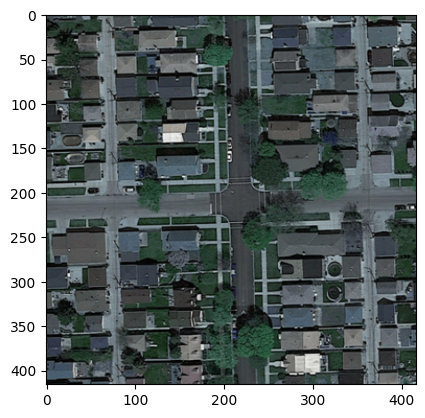

In [ ]:
plt.imshow(train_img[0], cmap="viridis")

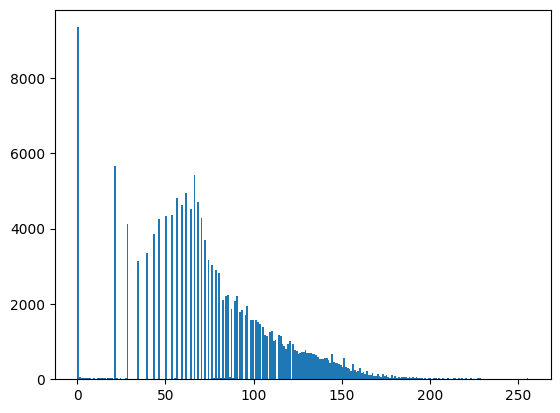

In [ ]:
plt.hist(train_img[0].ravel(), 256,[0,256])
plt.show()